<a href="https://colab.research.google.com/github/raflinoob132/MachineLearning-1/blob/main/Week%204/House%20Pricing/Colab%20Notebook/House_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

train_url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/04.%20Week%204/Datasets/FeatureEngineering/train.csv"
test_url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/04.%20Week%204/Datasets/FeatureEngineering/test.csv"

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (1460, 81)
Test shape: (1459, 80)


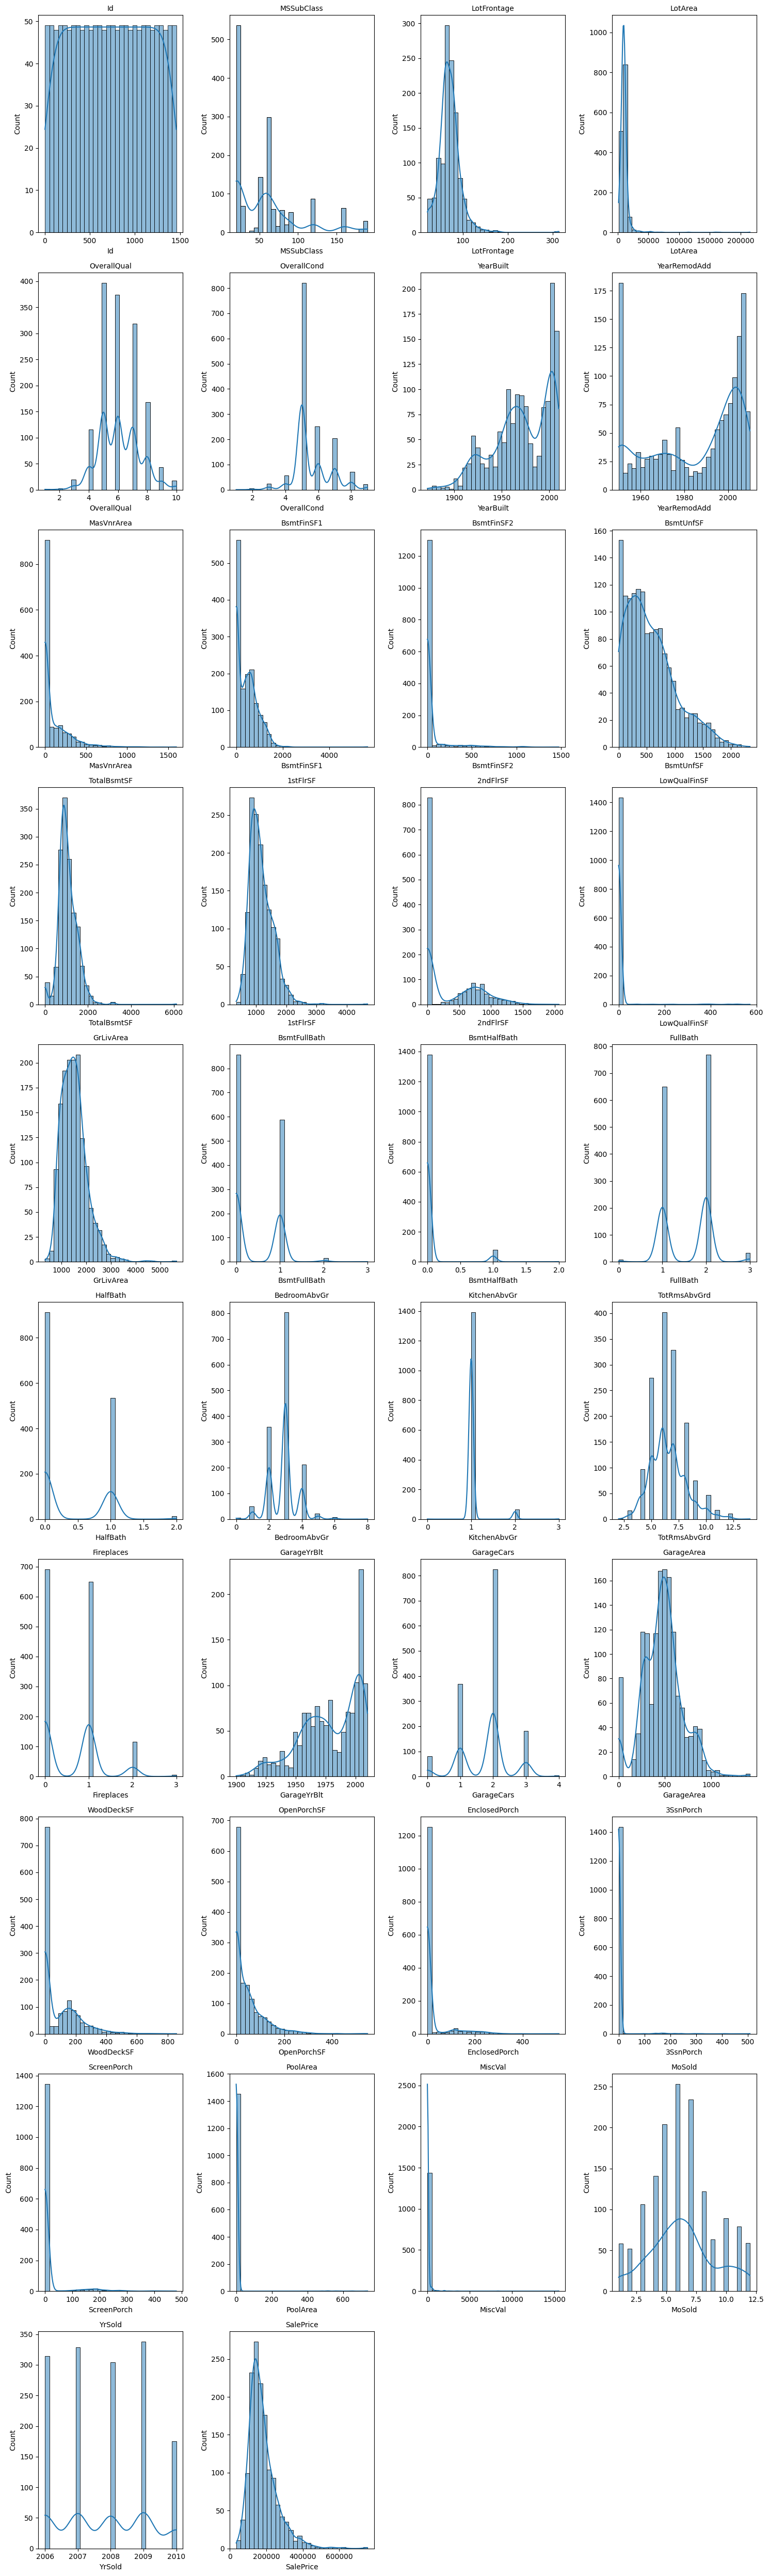

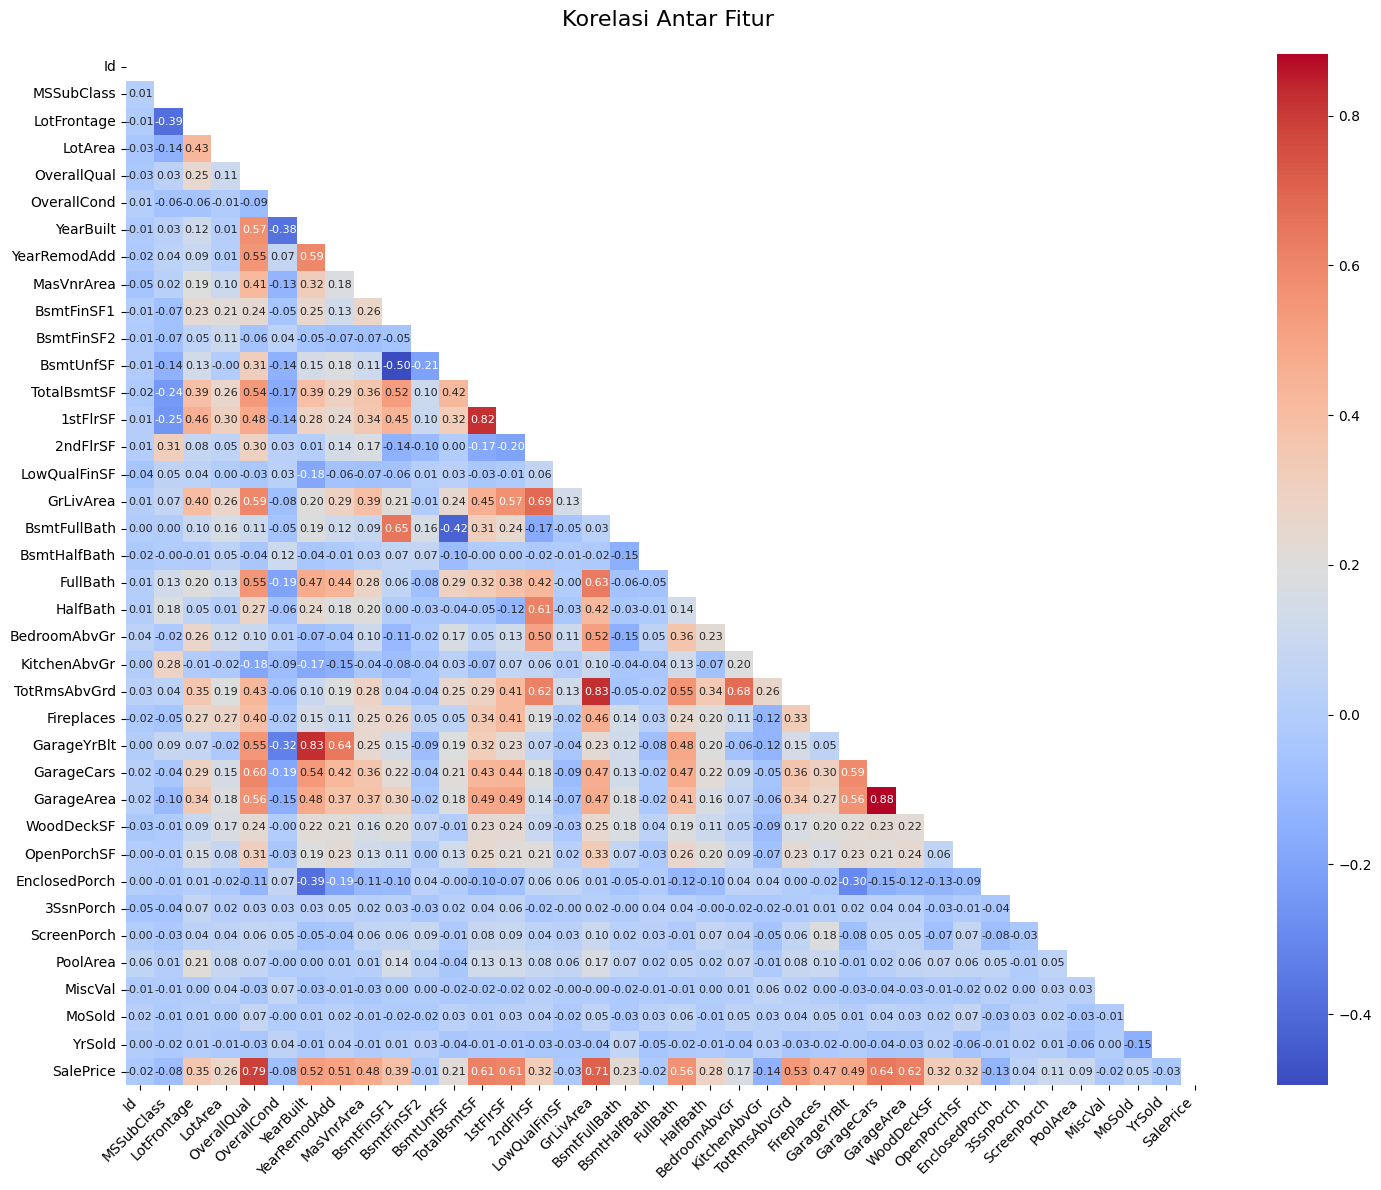

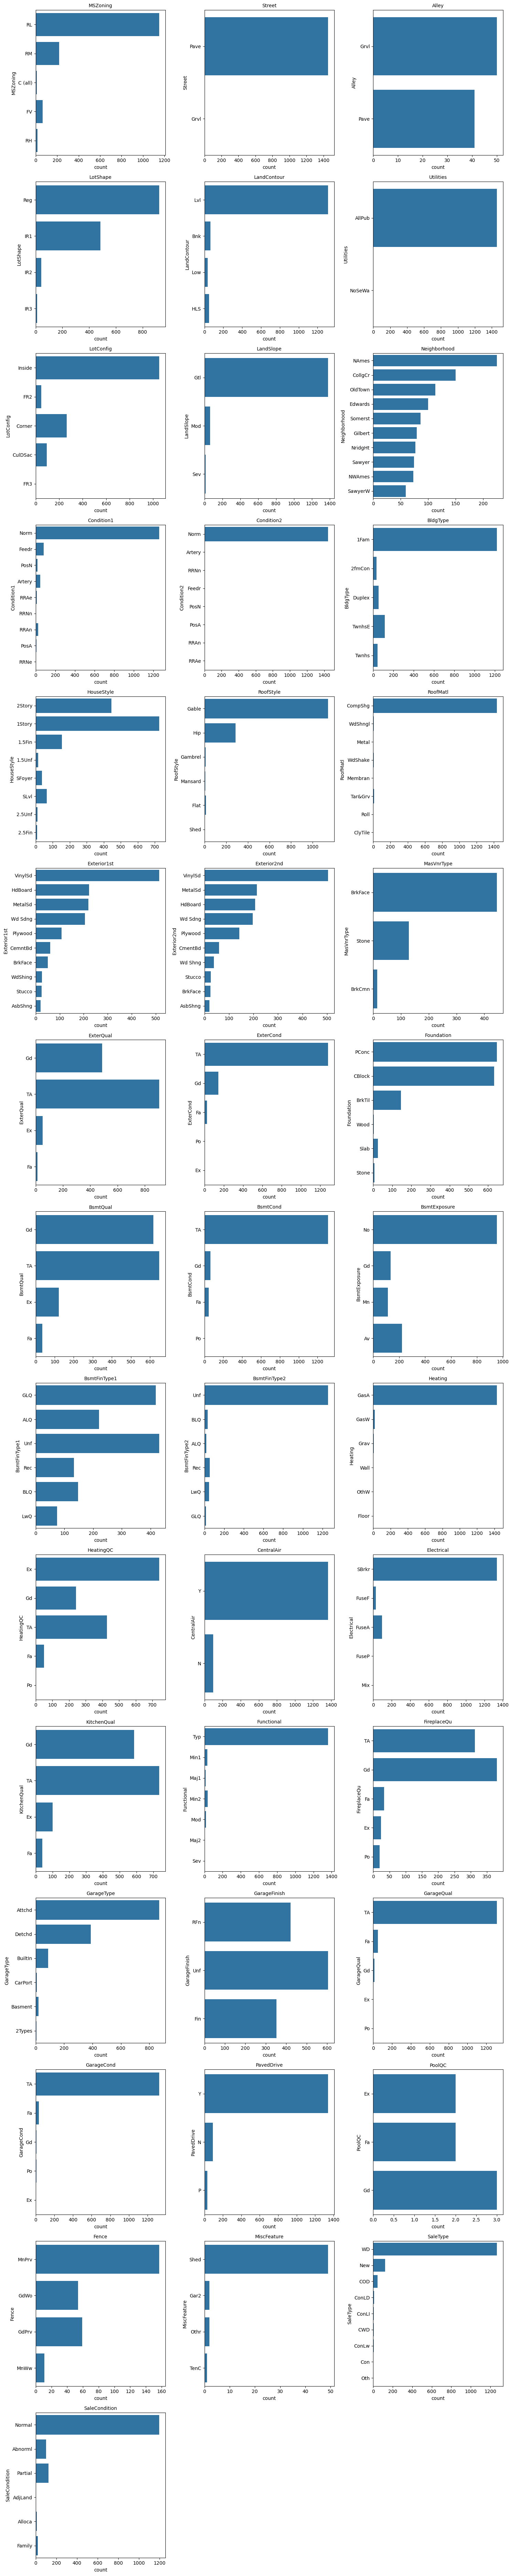

In [2]:
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_rows = int(np.ceil(len(numeric_cols) / 4))

plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, 4, i+1)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(col, fontsize=10)
    plt.tight_layout()
plt.show()

# Korelasi
plt.figure(figsize=(15, 12))
corr_matrix = train_df.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)), annot_kws={"size": 8})
plt.title("Korelasi Antar Fitur", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Fitur kategorikal
categorical_cols = train_df.select_dtypes(include=['object']).columns
num_rows = int(np.ceil(len(categorical_cols) / 3))

plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(categorical_cols):
    plt.subplot(num_rows, 3, i+1)
    if train_df[col].nunique() > 10:
        top_categories = train_df[col].value_counts().nlargest(10).index
        sns.countplot(y=col, data=train_df[train_df[col].isin(top_categories)], order=top_categories)
    else:
        sns.countplot(y=col, data=train_df)
    plt.title(col, fontsize=10)
    plt.tight_layout()
plt.show()

In [9]:
def handle_missing(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = df[col].fillna(df[col].median())
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df


def encode_categorical(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category').cat.codes
    return df

train_df = handle_missing(train_df)
test_df = handle_missing(test_df)
train_df = encode_categorical(train_df)
test_df = encode_categorical(test_df)

In [10]:
if all(col in train_df.columns for col in ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']):
    train_df['TotalArea'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
    test_df['TotalArea'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

# Transformasi log untuk fitur skewed
skewed_cols = train_df[numeric_cols].skew().sort_values(ascending=False)
highly_skewed = skewed_cols[abs(skewed_cols) > 0.75].index
for col in highly_skewed:
    if col != 'SalePrice':
        train_df[col] = np.log1p(train_df[col])
        test_df[col] = np.log1p(test_df[col])

In [11]:

print("\nMissing values after processing:")
print(train_df.isnull().sum().sum(), "in train")
print(test_df.isnull().sum().sum(), "in test")

diff_cols = set(train_df.columns) - set(test_df.columns)
if 'SalePrice' in diff_cols:
    X_train = train_df.drop('SalePrice', axis=1)
    y_train = train_df['SalePrice']
    X_test = test_df
else:
    X_train = train_df
    X_test = test_df



Missing values after processing:
0 in train
0 in test


In [15]:
model = LinearRegression()
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f"\nTraining RMSE: {train_rmse:.2f}")

if 'SalePrice' in test_df.columns:
    y_test = test_df['SalePrice']
    test_pred = model.predict(X_test.drop('SalePrice', axis=1))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    print(f"Test RMSE: {test_rmse:.2f}")

r2 = r2_score(y_train, train_pred)
print(f"R² Score: {r2:.4f}")

baseline_pred = np.full_like(y_train, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_train, baseline_pred))
print(f"Baseline RMSE (mean prediction): {baseline_rmse:.2f}")



Training RMSE: 30504.67
R² Score: 0.8525
Baseline RMSE (mean prediction): 79415.29


In [19]:
X_train_data, X_val_data, y_train_data, y_val_data = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    model.fit(X_train_data, y_train_data)
    train_pred = model.predict(X_train_data)
    val_pred = model.predict(X_val_data)
    train_rmse = np.sqrt(mean_squared_error(y_train_data, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_data, val_pred))
    r2 = r2_score(y_val_data, val_pred)

    results[name] = {
        'CV RMSE': cv_rmse,
        'Train RMSE': train_rmse,
        'Validation RMSE': val_rmse,
        'R² Score': r2
    }

    print(f"\n{name} Results:")
    print(f"CV RMSE: {cv_rmse:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Overfitting Ratio (Train/Val): {train_rmse/val_rmse:.4f}")


Linear Regression Results:
CV RMSE: 34968.3776
Train RMSE: 29065.8291
Validation RMSE: 37446.2509
R² Score: 0.8172
Overfitting Ratio (Train/Val): 0.7762

Random Forest Results:
CV RMSE: 30084.4888
Train RMSE: 11019.9071
Validation RMSE: 28379.7122
R² Score: 0.8950
Overfitting Ratio (Train/Val): 0.3883


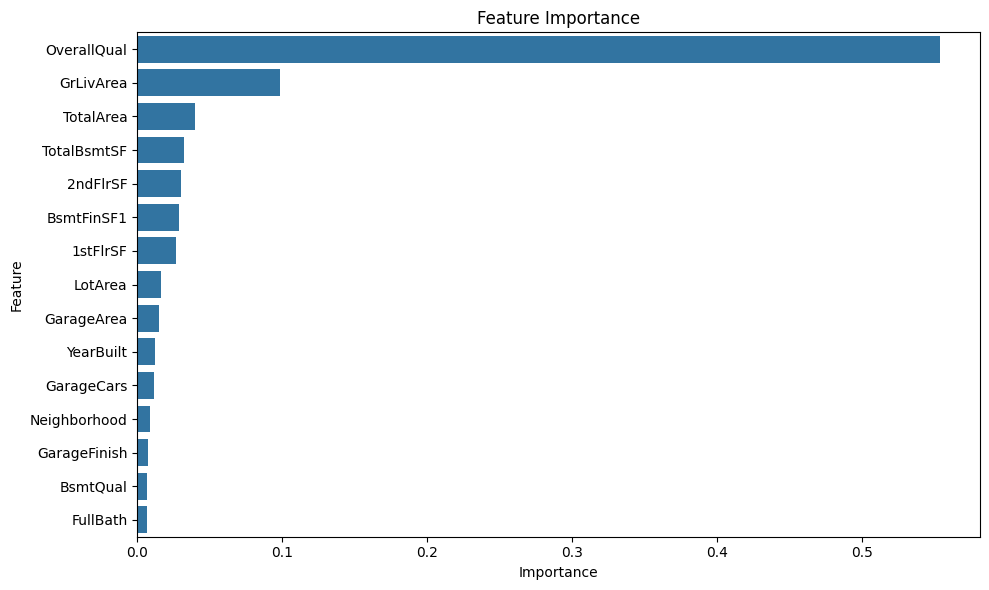

In [17]:

if 'Random Forest' in models:
    rf_model = models['Random Forest']
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importances.head(15))
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
